<a href="https://colab.research.google.com/github/bbberylll/ESAA_OB/blob/main/ESAA_OB_M14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 개념 정리

LSTM 순전파: LSTM은 기울기 소멸 문제 --> 망각, 입력, 출력 게이트를 은닉층의 각 뉴런에 추가해 해결함
- 망각 게이트: 과거 정보를 어느 정도 기억할지 결정
    - 과거 정보와 현재 데이터를 입력 받아 시그모이드를 취함 --> 과거 정보에 곱해줌
        - 출력이 0이면 과거 정보 망각 / 1이면 온전히 기억

- 입력 게이트: 현재 정보를 기억하기 위함
    - 과거 정보와 현재 데이터를 입력 받아 시그모이드와 tanh를 기반으로 현재 정보 보존량 결정

- 셀: 각 단계에 대한 은닉 노드
    - 총합을 사용하여 셀 값 반영, 기울기 소멸 문제 해결
    - 망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태를 업데이트

- 출력 게이트: 과거 정보와 현재 데이터를 사용하여 뉴런의 출력을 결정
    - 이전 은닉 상태와 t번째 입력을 고려해서 다음 은닉 상태를 계산
    - 계산한 값이 1이면 의미 있는 결과 / 0이면 해당 연산 출력 X

LSTM 역전파 : 셀을 통해 역전파 수행 >> 중단 없는 기울기

- 셀 단위로 역전파가 발생!!

## **[LSTM 셀 구현]**

- 사전에 전처리가 되지 않은 데이터셋의 경우, 정확도를 높이기 위해  
  은닉층의 개수(혹은 뉴런의 개수) 조정 및 하이퍼파라미터 수정이 필요함

---

### 1. MNIST 데이터셋을 내려 받기 위해 필요한 파라미터

- **MNIST를 내려받을 위치**
- **transform**
  - 데이터 전처리를 적용하기 위한 함수
- **train**
  - `True` : 훈련용 데이터셋
  - `False` : 테스트용 데이터셋
- **download**
  - `True`로 설정 시, 해당 위치에 파일이 없을 경우에만 다운로드 수행

---

### 2. LSTM 셀 네트워크 구축

- LSTM은 다음의 네 가지 게이트로 구성됨
  - 망각 게이트 (Forget Gate)
  - 입력 게이트 (Input Gate)
  - 셀 게이트 (Cell Gate)
  - 출력 게이트 (Output Gate)

- 게이트 계산식
  ```python
  gates = F.linear(input, w_ih, b_ih) + F.linear(hx, w_hh, b_hh)
  ```

- torch.chunk()
: 하나의 텐서를 여러 개의 텐서로 분할할 때 사용하는 함수

- uniform()
: 가중치 초기화를 위해 난수를 생성할 때 사용

- 하나의 LSTM 셀을 통과하면 다음 두 가지가 출력됨
  - 셀 상태 (cell state)
  - 은닉 상태 (hidden state)

### 3. LSTMCell 주요 파라미터
- input_dim : 입력 데이터의 특성(feature) 수
- hidden_dim : 은닉층의 뉴런 개수
- layer_dim : 은닉층의 계층(layer) 개수

## **[LSTM 계층 구현]**
결과가 만족스럽지 않을 경우 하이퍼파라미터 튜닝뿐만 아니라 모델 구조 자체를 변경해보는 것도 중요함

## **데이터셋과 네트워크 입력 형태**
- 모든 데이터셋은 그 자체로 네트워크에 입력할 수 없음
- 네트워크에서 정의된 입력 형태(shape)와 크기에 맞게
데이터셋의 크기를 조정해야 함

### axvline()
그래프에서 특정 지점을 기준으로 수직선을 표시할 때 사용하는 함수

- 파라미터
    1. 첫 번째 파라미터 : 수직선을 표시할 x축 위치
    2. c : 수직선의 색상
    3. linestyle : 수직선의 스타일

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device( 'cuda:8' if torch.cuda.is_available() else 'cpu' )
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [2]:
import torchvision.transforms as transforms
mnist_transform = transforms.Compose([
transforms.ToTensor() ,
transforms.Normalize( (0.5, ), (1.0, ))
])

In [3]:
from torchvision.datasets import MNIST
download_root = '/content/drive/MyDrive'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST( download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST( download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.9MB/s]


In [4]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
shuffle=True)

In [5]:
batch_size=100
n_iters=6000
num_epochs=n_iters/(len(train_dataset)/batch_size)
num_epochs=int(num_epochs)

In [6]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell , self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear( input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear( hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1 , x.size(1))

        gates = self.x2h(x) + self.h2h(hx )
        gates= gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates. chunk (4, 1)

        ingate = F.sigmoid (ingate)
        forgetgate = F.sigmoid (forgetgate)
        cellgate = F.tanh (cellgate)
        outgate = F.sigmoid (outgate)

        cy = torch.mul(cx,forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return (hy , cy)

In [7]:
class LSTMModel(nn.Module ):
    def __init__(self, input_dim, hidden_dim, layer_dim , output_dim , bias=True ):
        super(LSTMModel , self). __init__()
        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim
        self.lstm = LSTMCell( input_dim , hidden_dim , layer_dim )
        self.fc = nn.Linear(hidden_dim , output_dim )

    def forward(self, x):
        if torch.cuda.is_available():
            h0 = Variable( torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0),hidden_dim))

        outs=[]
        cn=c0[0,:,:]
        hn=h0[0,:,:]

        for seq in range(x.size(1)):
            hn,cn=self.lstm(x[:, seq, :], (hn,cn))
            outs.append(hn)

        out=outs[-1].squeeze()
        out=self.fc(out)
        return out



In [8]:
input_dim=28
hidden_dim=128
layer_dim=1
output_dim=10

model = LSTMModel( input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
    model.cuba()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters() , lr=learning_rate)

In [9]:
seq_dim = 28
loss_list = []
iter = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        if torch.cuda.is_available():
            images = images.view(-1, seq_dim, input_dim).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, seq_dim, input_dim)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0

            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = images.view(-1, seq_dim, input_dim).cuda()
                    labels = labels.cuda()
                else:
                    images = images.view(-1, seq_dim, input_dim)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            print(f'Iteration: {iter}. Loss: {loss.item():.4f}. Accuracy: {accuracy:.2f}%')


Iteration: 500. Loss: 2.2375. Accuracy: 21.42%
Iteration: 1000. Loss: 0.8734. Accuracy: 75.62%
Iteration: 1500. Loss: 0.4365. Accuracy: 88.90%
Iteration: 2000. Loss: 0.2349. Accuracy: 93.30%
Iteration: 2500. Loss: 0.0647. Accuracy: 95.72%
Iteration: 3000. Loss: 0.0730. Accuracy: 96.14%
Iteration: 3500. Loss: 0.1042. Accuracy: 96.39%
Iteration: 4000. Loss: 0.0170. Accuracy: 97.04%
Iteration: 4500. Loss: 0.0540. Accuracy: 96.98%
Iteration: 5000. Loss: 0.0708. Accuracy: 97.18%
Iteration: 5500. Loss: 0.1159. Accuracy: 97.38%
Iteration: 6000. Loss: 0.0133. Accuracy: 97.51%
Iteration: 6500. Loss: 0.0204. Accuracy: 97.57%
Iteration: 7000. Loss: 0.0155. Accuracy: 98.02%
Iteration: 7500. Loss: 0.0291. Accuracy: 97.79%
Iteration: 8000. Loss: 0.0872. Accuracy: 97.54%
Iteration: 8500. Loss: 0.0162. Accuracy: 98.05%
Iteration: 9000. Loss: 0.0353. Accuracy: 97.81%


In [12]:
def evaluate (model , val_iter) :
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images , labels in val_iter:
        if torch.cuda.is_available():
            images = Variable( images. view(-1 , seq_dim, input_dim).cuda())
        else :
            images = Variable( images. view(-1 , seq_dim, input_dim)).to(device)

        logit=model(images).to(device)
        loss = F. cross_entropy (logit , labels , reduction="sum" )
        _, predicted = torch.max(logit . data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len (val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [13]:
test_loss , test_acc = evaluate(model, test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc) )

Test Loss:  0.06 | Test Accuracy:  0.98


In [14]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch .autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu' )

In [17]:
url = 'https://raw.githubusercontent.com/gilbutITbook/080289/refs/heads/main/chap07/data/SBUX.csv'

data=pd.read_csv(url)
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [18]:
print(data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [19]:
data[ 'Date' ] = pd.to_datetime(data[ 'Date'])
data.set_index('Date', inplace=True )

In [20]:
data['Volume'] = data ['Volume'].astype(float)

In [21]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [22]:
ms=MinMaxScaler()
ss=StandardScaler()

X_ss=ss.fit_transform(X)
y_ms=ms.fit_transform(y)

X_train=X_ss[:200, :]
X_test=X_ss[200:,:]

y_train= y_ms[:200,:]
y_test=y_ms[200:,:]

print("Training Shape" , X_train.shape, y_train.shape)
print("Testing Shape" , X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [23]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[ 0], X_test_tensors.shape[1]))
print("Training Shape" , X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape" , X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 5]) torch.Size([53, 1])


In [24]:
class LSTM (nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM( input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128 , num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn , cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view ( -1, self. hidden_size)
        out = self.relu(hn )
        out = self.fc_1(out)
        out= self.relu(out)
        out = self.fc(out)
        return out

In [25]:
num_epochs = 1000
learning_rate = 0.0001
input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1
model = LSTM( num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
print(X_train_tensors_f.shape)
print(X_train_tensors_f.numel())  # 총 요소 수

torch.Size([200, 5])
1000


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if X_train_tensors_f.dim() == 2:
    X_train_tensors_f = X_train_tensors_f.unsqueeze(1)

X_train_tensors_f = X_train_tensors_f.float().to(device)
y_train_tensors   = y_train_tensors.float().to(device)


if y_train_tensors.dim() == 1:
    y_train_tensors = y_train_tensors.unsqueeze(1)

print("X:", X_train_tensors_f.shape, X_train_tensors_f.device)
print("y:", y_train_tensors.shape, y_train_tensors.device)

batch_size, seq_len, input_dim = X_train_tensors_f.shape
hidden_dim = 128
num_layers = 2
output_dim = 1
num_epochs = 1000

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # hidden state 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
criterion = nn.MSELoss()  # 회귀 예제 기준
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensors_f)
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item():.5f}")

X: torch.Size([200, 1, 5]) cpu
y: torch.Size([200, 1]) cpu
Epoch: 0, Loss: 0.09528
Epoch: 100, Loss: 0.01772
Epoch: 200, Loss: 0.01520
Epoch: 300, Loss: 0.01147
Epoch: 400, Loss: 0.01062
Epoch: 500, Loss: 0.01041
Epoch: 600, Loss: 0.01026
Epoch: 700, Loss: 0.01012
Epoch: 800, Loss: 0.01002
Epoch: 900, Loss: 0.00992


In [32]:
df_x_ss = ss.transform( data. iloc[ :, :-1])
df_y_ms = ms.transform(data. iloc[ :, -1:])
df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

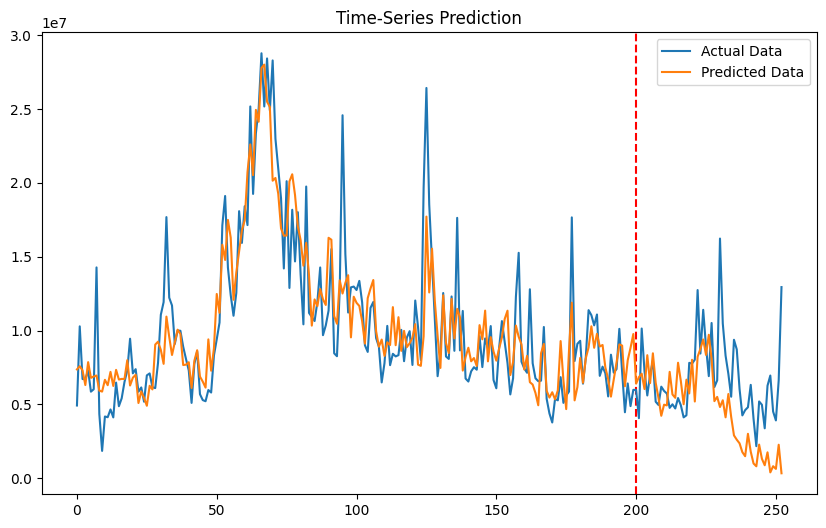

In [33]:
train_predict = model( df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform( predicted)
label_y = ms.inverse_transform(label_y)
plt.figure( figsize=( 10,6))
plt.axvline(x=200, c= 'r', linestyle= '--' )

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title( 'Time-Series Prediction' )
plt.legend()
plt.show()